In [81]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.86 µs


In [82]:
#def reset_esn()の定義
#reset_esn()は一体何に使うのか？

def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout

In [99]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import math

# ロスラー方程式に外力としての正弦波を追加するための関数
def rossler_with_external_force(t, state, a, b, c, A, omega):
    x, y, z = state  # Unpack the values from the state vector
    # 外力としての正弦波を加える（振幅Aを掛ける）
    dxdt = -y - z + A * math.sin(omega * t)
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

a = 0.2
b = 0.2
c = 5.7
A = 1.2  # 外力の振幅
omega = 1.0  # 外力の角周波数
initial_state = [1.0, 1.0, 1.0]
t_span = (0, 2510)

# solve_ivpによる解法、ここでは外力の振幅と角周波数を追加のパラメータとして渡す
sol = solve_ivp(rossler_with_external_force, t_span, initial_state, args=(a, b, c, A, omega), dense_output=True, t_eval=np.linspace(t_span[0], t_span[1], 25100), max_step=0.01)

t = sol.t
z = sol.y
external_force = A * np.sin(omega * t)  # 外力としての正弦波を計算（振幅Aを掛ける）

# CSVファイルにデータを保存
data = pd.DataFrame({'Time': t, 'x': z[0], 'y': z[1], 'z': z[2], 'external_force': external_force})
data.to_csv('rossler_with_external_force.csv', index=False)

# CSVファイルを読み込む
data_loaded = pd.read_csv('rossler_with_external_force.csv')

# 配列を確認
X = data_loaded[['x', 'y', 'external_force']].values
X.shape


(25100, 3)

In [84]:
best = ({'N': 0,'iss': 0.15716834911966804,'lr': 0.8156304946175557,'ridge': 4.290374941230941e-08, 'seed': 0, 'sr': 1.0385323042151453})

In [85]:
# 描画用のplot_generationの定義

def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

In [86]:
nb_generations = 500
seed_timesteps = 100

In [87]:
def esn_chaos_prediction(X, N, iss, lr, ridge, seed, sr,  seed_timesteps, nb_generations, train_len = 2000, forecast=1):
    
    n, m = X.shape
    
    from reservoirpy.datasets import to_forecasting

    train_len = train_len

    x, y = to_forecasting(X, forecast=forecast)
    X_train, y_train = x[:train_len], y[:train_len]
    X_test, y_test = x[train_len:], y[train_len:]

    dataset = ((X_train, y_train), (X_test, y_test))
    
    # bestから取得したハイパーパラメータを設定
    N = N
    iss = iss
    lr = lr
    ridge = ridge
    seed = seed
    sr = sr

    # データセットからトレーニングとバリデーションデータを取得
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data

    # モデルの構築
    reservoir = Reservoir(N, 
                        sr=sr, 
                        lr=lr, 
                        input_scaling=iss, 
                        seed=seed)
    readout = Ridge(ridge=ridge)
    model = reservoir >> readout
    
    warming_inputs = X_test[:seed_timesteps]

    warming_out = model.fit(X_train, y_train).run(warming_inputs, reset=True)  # warmup
    
    X_gen = np.zeros((nb_generations, m))
    y = warming_out[-1]
    for t in range(nb_generations):  # generation
        y = model(y)
        X_gen[t, :] = y
        
    X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]
    
    return X_gen, X_t, warming_out, warming_inputs

In [ ]:
best = ({'N': 0,
  'iss': 0.15716834911966804,
  'lr': 0.8156304946175557,
  'ridge': 4.290374941230941e-08,
  'seed': 0,
  'sr': 1.0385323042151453})

In [ ]:
N = 500
iss = best[0]['iss']
lr = best[0]['lr']
ridge = best[0]['ridge']
seed = 1234
sr = best[0]['sr']

In [88]:
X_gen, X_t, warming_out, warming_inputs = esn_chaos_prediction(X, 500,  best[0]['iss'], best[0]['lr'], best[0]['ridge'], 1234, best[0]['sr'], seed_timesteps, nb_generations)

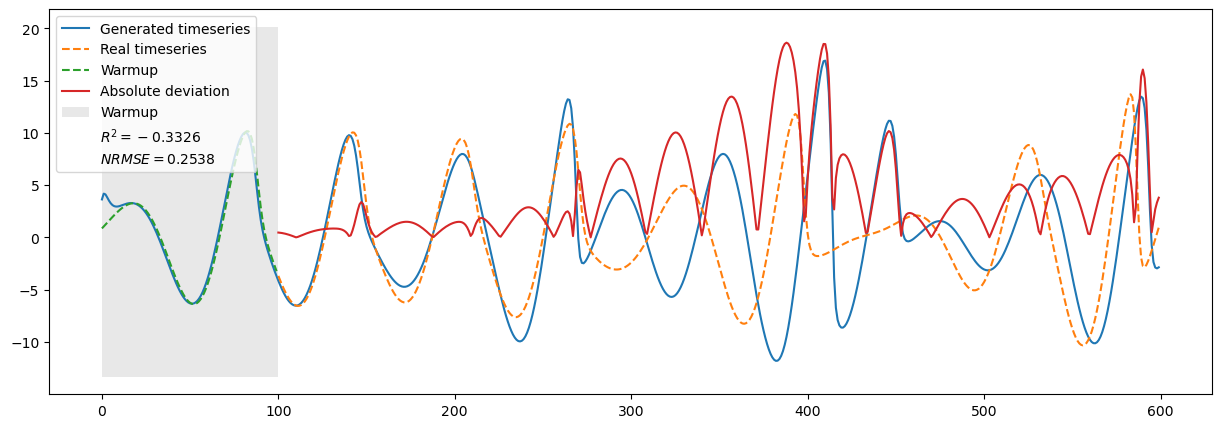

In [89]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

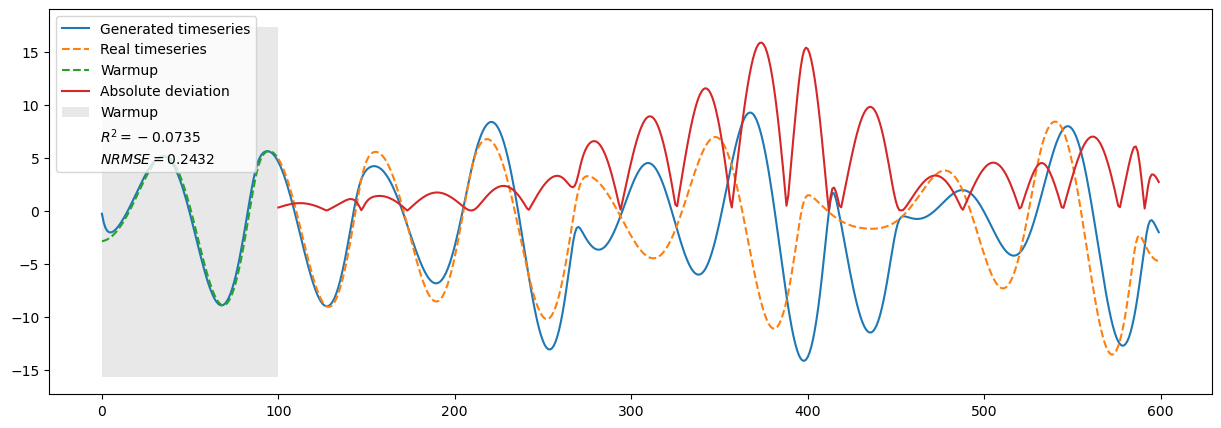

In [90]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)

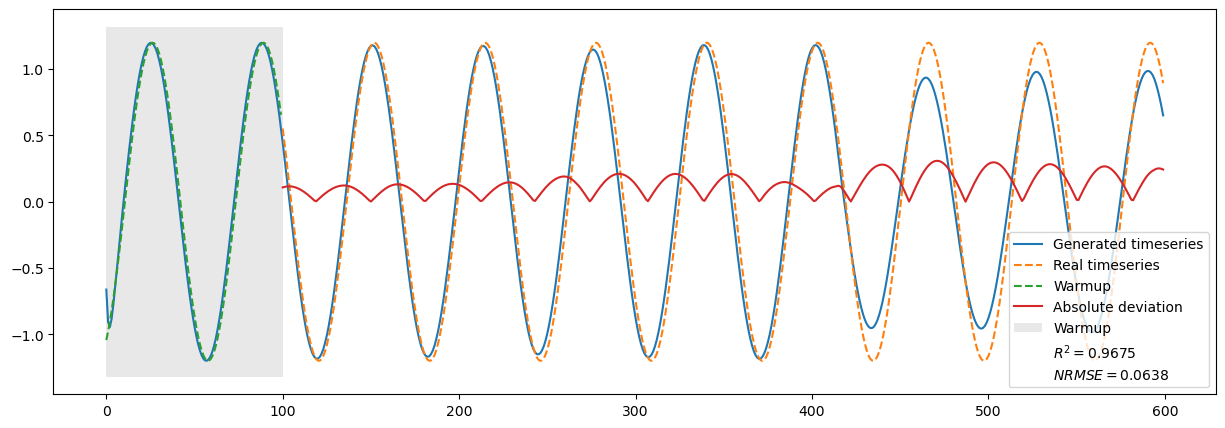

In [91]:
plot_generation(X_gen[:, 2:3], X_t[:, 2:3], nb_generations, warming_out=warming_out[:, 2:3],
                warming_inputs=warming_inputs[:, 2:3], seed_timesteps=seed_timesteps)

In [92]:
train_len = 2000 
forecast=1 
seed_timesteps = 100 
nb_generations = 400

    
n, m = X.shape
    
from reservoirpy.datasets import to_forecasting

train_len = train_len

x, y = to_forecasting(X, forecast=forecast)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:], y[train_len:]

dataset = ((X_train, y_train), (X_test, y_test))

# bestから取得したハイパーパラメータを設定
N = 3849
iss = 0.14258024657972923
lr = 0.5516837456874331
ridge = 3.7433235003717447e-07
seed = 1234
sr = 0.1931498404234262

# データセットからトレーニングとバリデーションデータを取得
train_data, validation_data = dataset
X_train, y_train = train_data
X_val, y_val = validation_data

# モデルの構築
reservoir = Reservoir(N, 
                    sr=sr, 
                    lr=lr, 
                    input_scaling=iss, 
                    seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_val)

In [93]:
seed_timesteps = 100
nb_generations = 400
#実際は150ステップに対応

warming_inputs = X_test[:seed_timesteps]

warming_out = model.run(warming_inputs, reset=True)  # warmup
print(f"{warming_out[-1]}:warming_out[-1]")
print(f"{X_test[seed_timesteps]}:X_test[seed_timesteps]")
#warming_outはX_test[seed_timesteps]を近似する．

[-3.67449415  4.88759855  0.55233361]:warming_out[-1]
[-3.67236068  4.88690288  0.55236834]:X_test[seed_timesteps]


In [94]:
X_gen = np.zeros((nb_generations, m))
y = warming_out[-1] 
print(y.shape) 
y = y.reshape(1, -1) 
print(y.shape) #配列の形式は(n, m)の二次元配列にする必要があるので調整した

(3,)
(1, 3)


In [95]:
for t in range(nb_generations):  
    y[:, 2:3] = X_test[seed_timesteps+t, 2:3] #外力にあたる[:, 2:3]に実測値を代入する．
    y = model(y) #ESNで1回=0.1ステップ先を予測する．
    X_gen[t, :] = y #配列に記録していく
            
X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]

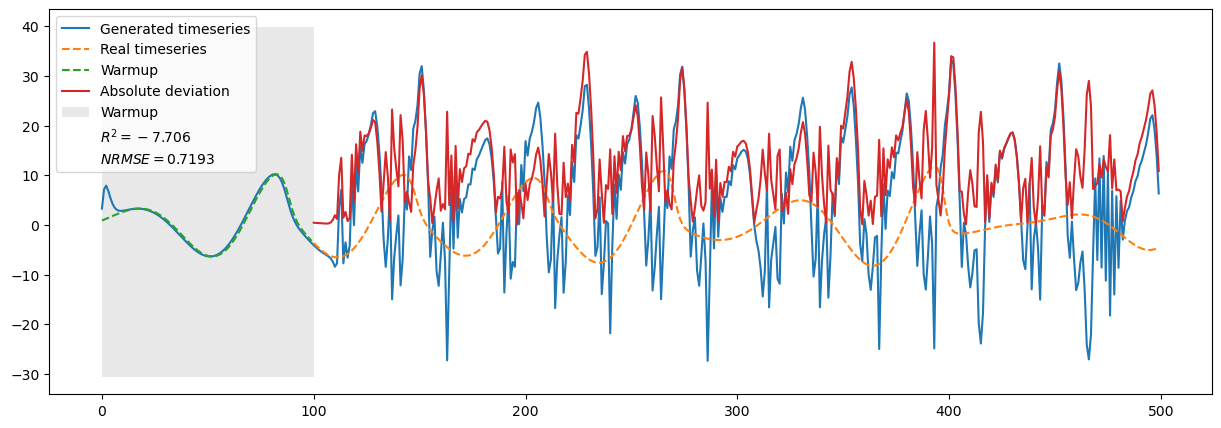

In [96]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

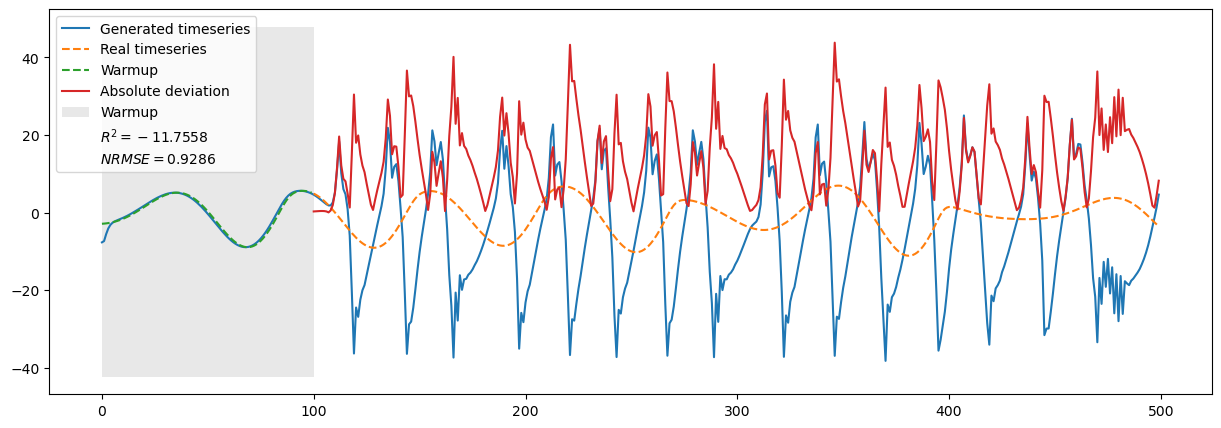

In [97]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)

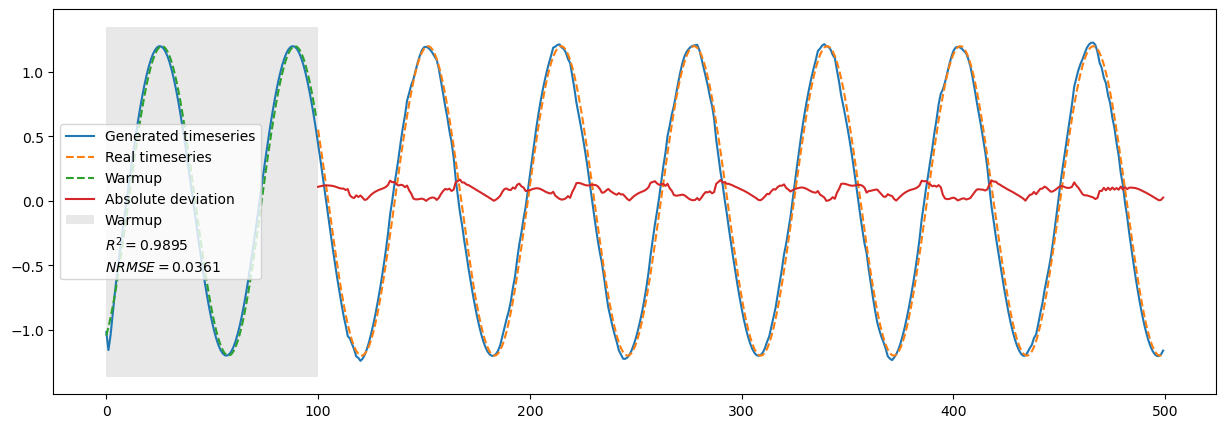

In [98]:
plot_generation(X_gen[:, 2:3], X_t[:, 2:3], nb_generations, warming_out=warming_out[:, 2:3],
                warming_inputs=warming_inputs[:, 2:3], seed_timesteps=seed_timesteps)